# 4 - Partial Least Squares Regression


**The Partial Least Squares regression (PLS) is a method which reduces the variables, used to predict, to a smaller set of predictors. These predictors are then used to perfom a regression.**

# Get dataset

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Get dataset
df = pd.read_csv("Hitters.csv")
data = df.copy()
data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [2]:
data.isnull().values.any()

True

In [3]:
data = data.dropna()
data.isnull().values.any()

False

# Create Dummy Variables

In [5]:
dummies = pd.get_dummies(data[["League","Division","NewLeague"]])
dummies.head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [11]:
y = data["Salary"]

X_pre = data.drop(["Salary","League","Division","NewLeague"],axis=1).astype("float64")
X = pd.concat([X_pre,dummies[["League_N","Division_W","NewLeague_N"]]],axis=1)
X.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,League_N,Division_W,NewLeague_N
1,315.0,81.0,7.0,24.0,38.0,39.0,14.0,3449.0,835.0,69.0,321.0,414.0,375.0,632.0,43.0,10.0,1,1,1
2,479.0,130.0,18.0,66.0,72.0,76.0,3.0,1624.0,457.0,63.0,224.0,266.0,263.0,880.0,82.0,14.0,0,1,0
3,496.0,141.0,20.0,65.0,78.0,37.0,11.0,5628.0,1575.0,225.0,828.0,838.0,354.0,200.0,11.0,3.0,1,0,1
4,321.0,87.0,10.0,39.0,42.0,30.0,2.0,396.0,101.0,12.0,48.0,46.0,33.0,805.0,40.0,4.0,1,0,1
5,594.0,169.0,4.0,74.0,51.0,35.0,11.0,4408.0,1133.0,19.0,501.0,336.0,194.0,282.0,421.0,25.0,0,1,0


# Split train and test

In [12]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=33)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(210, 19)
(210,)
(53, 19)
(53,)


# Import model

In [13]:
from sklearn.cross_decomposition import PLSRegression

plsReg = PLSRegression(n_components=5)
plsModel = plsReg.fit(X_train,y_train)

plsModel.coef_

array([[ -65.47688741],
       [ 112.5918001 ],
       [ -88.53869885],
       [  39.68656717],
       [  -0.19027158],
       [  75.41441635],
       [-100.82337211],
       [   6.36621461],
       [  77.40677158],
       [ 126.16924699],
       [  84.45580749],
       [ 116.11038829],
       [ -69.45216391],
       [  85.61533069],
       [  42.51378463],
       [ -47.31956177],
       [  38.1860217 ],
       [ -61.12219718],
       [ -36.90893364]])

# Predict and Find Loss Values

In [15]:
from sklearn.metrics import mean_squared_error

y_pred = plsModel.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
rmse = np.sqrt(mse)

print(f"MSE Train = {mse}")
print(f"RMSE Train = {rmse}")

MSE Train = 108896.82694806595
RMSE Train = 329.99519231053347


In [17]:
# Find test loss
y_pred_test = plsModel.predict(X_test)
mse_test = mean_squared_error(y_test,y_pred_test)
rmse_test = np.sqrt(mse_test)

print(f"MSE Test = {mse_test}")
print(f"RMSE Test = {rmse_test}")

MSE Test = 76070.6611125438
RMSE Test = 275.8091026644041


# Model Tuning

In [20]:
from sklearn.model_selection import KFold,cross_val_score

# Find cross-validation fold
cv_10 = KFold(n_splits=10,shuffle=True,random_state=33)

# Create list that holds the loss values for each fold
RMSE_values = []

max_variable_size = X_train.shape[1]

for i in range(1,max_variable_size+1):
    pls = PLSRegression(n_components=i)
    rmse_value = np.sqrt(-cross_val_score(pls,X_train,y_train,
                                          cv=cv_10,scoring="neg_mean_squared_error").mean())
    RMSE_values.append(rmse_value)
    
np.array(RMSE_values)

array([367.83053834, 367.8632133 , 366.17262575, 361.18154617,
       364.67153275, 361.60675259, 360.7614397 , 355.63368541,
       358.106676  , 358.43762696, 354.82640732, 356.81853645,
       358.83999048, 360.18475795, 359.84775243, 360.30632617,
       360.46093432, 361.47988716, 365.60684464])

# Plot the results

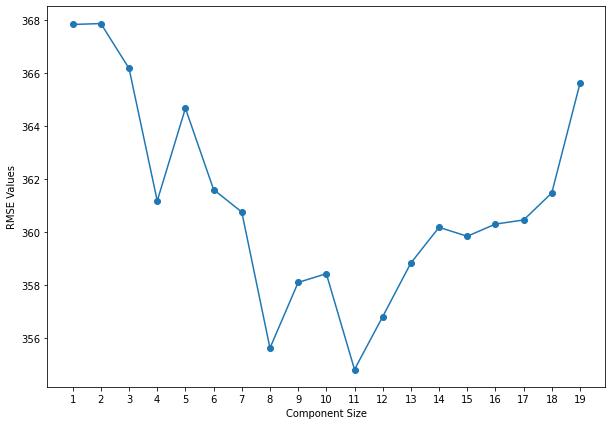

In [40]:
plt.figure(figsize=(10,7))

plt.plot(np.arange(1,max_variable_size+1),np.array(RMSE_values),marker="o")
plt.xlabel("Component Size")
plt.ylabel("RMSE Values")
plt.xticks(np.arange(1,max_variable_size+1));

In [42]:
optimumParameter = np.array(RMSE_values).argmin()
print(f"Optimum Parameter = {optimumParameter}")

Optimum Parameter = 10


# Create model with Tuned Hyperparameters

In [43]:
plsTuned = PLSRegression(n_components=optimumParameter).fit(X_train,y_train)

# Predict with tuned model
y_pred_tuned = plsTuned.predict(X_train)
mse_train_tuned = mean_squared_error(y_train,y_pred_tuned)
rmse_train_tuned = np.sqrt(mse_train_tuned)

print(f"MSE Train Tuned Loss = {mse_train_tuned}")
print(f"RMSE Train Tuned Loss = {rmse_train_tuned}")


MSE Train Tuned Loss = 100989.62986680793
RMSE Train Tuned Loss = 317.7886559756467
